In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision import models
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_transforms(target_dataset=False):
    if target_dataset:
        transform_list = [
            transforms.Resize((32, 32)),
            transforms.Grayscale(num_output_channels=3),  # Convert MNIST 1-channel to 3-channel
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    else:
        transform_list = [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    return transforms.Compose(transform_list)


In [ ]:
def get_dataloaders(batch_size=64, val_split=0.1):
    stl10_train_full = datasets.STL10(root="./data", split='train', download=True, transform=get_transforms())
    mnist_train_full = datasets.FashionMNIST(root="./data", train=True, download=True, transform=get_transforms(target_dataset=True))
    mnist_test = datasets.FashionMNIST(root="./data", train=False, download=True, transform=get_transforms(target_dataset=True))

    val_size = int(val_split * len(stl10_train_full))
    train_size = len(stl10_train_full) - val_size
    stl10_train, stl10_val = random_split(stl10_train_full, [train_size, val_size])

    val_size_mnist = int(val_split * len(mnist_train_full))
    train_size_mnist = len(mnist_train_full) - val_size_mnist
    mnist_train, mnist_val = random_split(mnist_train_full, [train_size_mnist, val_size_mnist])

    return {
        'stl10': DataLoader(stl10_train, batch_size=batch_size, shuffle=True),
        'stl10_val': DataLoader(stl10_val, batch_size=batch_size, shuffle=False),
        'mnist_train': DataLoader(mnist_train, batch_size=batch_size, shuffle=True),
        'mnist_val': DataLoader(mnist_val, batch_size=batch_size, shuffle=False),
        'mnist_test': DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
    }

In [ ]:
def get_pretrained_model():
    model = models.resnet18(pretrained=False, num_classes=10)  # STL-10 has 10 classes
    return model.to(device)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    best_loss = np.inf
    early_stop_counter = 0
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        val_running_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_running_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            early_stop_counter = 0
            best_model_wts = copy.deepcopy(model.state_dict())
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses

In [ ]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Epochs')
    plt.show()

In [ ]:
def apply_transfer_strategy(model, strategy):
    if strategy == 1:  # Train only linear layers
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif strategy == 2:  # Freeze initial layers, train others
        for param in list(model.parameters())[:10]:
            param.requires_grad = False
    elif strategy == 3:  # Fine-tune everything
        for param in model.parameters():
            param.requires_grad = True
    return model.to(device)

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"\nAccuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n")
    print(classification_report(all_labels, all_preds, digits=4))
    print('\n')

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
def visualize_predictions(model, data_loader, num_images=5):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    for i in range(num_images):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # Unnormalize
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Pred: {preds[i].item()}, GT: {labels[i].item()}")
    plt.show()

In [ ]:
loaders = get_dataloaders()

print("Pretraining on STL-10...")
model = get_pretrained_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 2.64G/2.64G [10:42<00:00, 4.11MB/s]


Extracting ./data/stl10_binary.tar.gz to ./data


100%|██████████| 26.4M/26.4M [00:00<00:00, 112MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 4.12MB/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 65.8MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 26.6MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Pretraining on STL-10...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


**Using the resnet-18 cnn architecture for Pre-Training on STL10 dataset**

In [ ]:
model, train_losses, val_losses = train_model(model, loaders['stl10'], loaders['stl10_val'], criterion, optimizer, num_epochs=10)

Epoch 1/10, Train Loss: 1.8215, Train Acc: 0.3422, Val Loss: 1.6020, Val Acc: 0.4000
Epoch 2/10, Train Loss: 1.4672, Train Acc: 0.4513, Val Loss: 1.6375, Val Acc: 0.3920
Epoch 3/10, Train Loss: 1.2949, Train Acc: 0.5280, Val Loss: 1.5322, Val Acc: 0.4240
Epoch 4/10, Train Loss: 1.1120, Train Acc: 0.6018, Val Loss: 1.6292, Val Acc: 0.4280
Epoch 5/10, Train Loss: 0.9507, Train Acc: 0.6598, Val Loss: 1.6022, Val Acc: 0.4560
Epoch 6/10, Train Loss: 0.7971, Train Acc: 0.7178, Val Loss: 1.6495, Val Acc: 0.4920
Early stopping triggered.


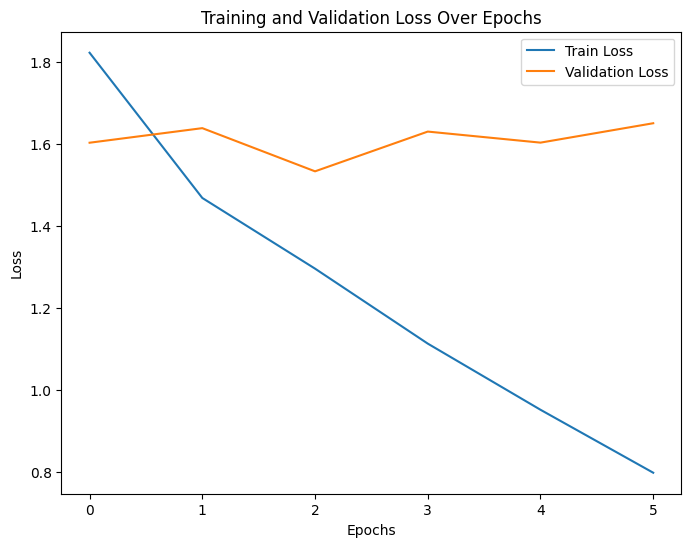

In [ ]:
plot_losses(train_losses, val_losses)

**Applying transfer learning**

In [ ]:
print(f"Evaluating Transfer Strategy {1}...")
adapted_model_1 = apply_transfer_strategy(copy.deepcopy(model), 1)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, adapted_model_1.parameters()), lr=0.001)
adapted_model_1, train_losses_1, val_losses_1 = train_model(adapted_model_1, loaders['mnist_train'], loaders['mnist_val'], criterion, optimizer, num_epochs=10)

Evaluating Transfer Strategy 1...
Epoch 1/10, Train Loss: 0.7761, Train Acc: 0.7339, Val Loss: 0.6163, Val Acc: 0.7775
Epoch 2/10, Train Loss: 0.6066, Train Acc: 0.7843, Val Loss: 0.5749, Val Acc: 0.7927
Epoch 3/10, Train Loss: 0.5664, Train Acc: 0.7989, Val Loss: 0.5353, Val Acc: 0.8083
Epoch 4/10, Train Loss: 0.5435, Train Acc: 0.8053, Val Loss: 0.5126, Val Acc: 0.8115
Epoch 5/10, Train Loss: 0.5275, Train Acc: 0.8112, Val Loss: 0.5114, Val Acc: 0.8117
Epoch 6/10, Train Loss: 0.5115, Train Acc: 0.8153, Val Loss: 0.5044, Val Acc: 0.8163
Epoch 7/10, Train Loss: 0.5068, Train Acc: 0.8188, Val Loss: 0.4839, Val Acc: 0.8208
Epoch 8/10, Train Loss: 0.5008, Train Acc: 0.8185, Val Loss: 0.4937, Val Acc: 0.8167
Epoch 9/10, Train Loss: 0.4946, Train Acc: 0.8208, Val Loss: 0.4766, Val Acc: 0.8237
Epoch 10/10, Train Loss: 0.4885, Train Acc: 0.8226, Val Loss: 0.4685, Val Acc: 0.8303


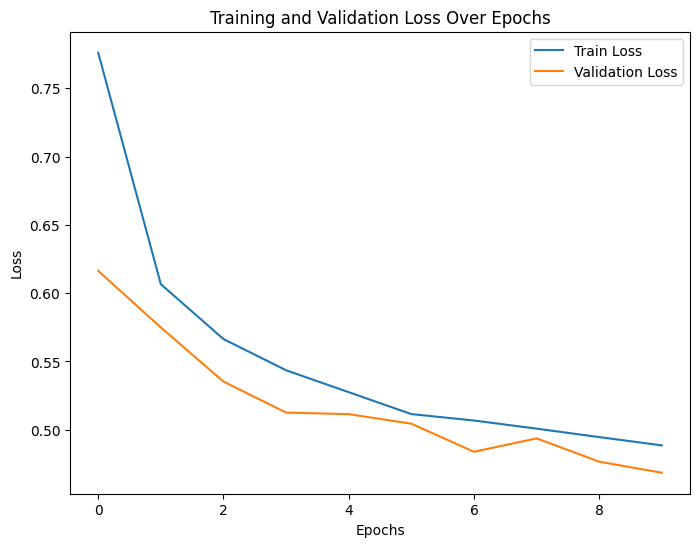


Accuracy: 0.8224, Precision: 0.8210, Recall: 0.8224, F1 Score: 0.8213

              precision    recall  f1-score   support

           0     0.7726    0.7680    0.7703      1000
           1     0.9635    0.9500    0.9567      1000
           2     0.6984    0.6670    0.6824      1000
           3     0.7765    0.8580    0.8152      1000
           4     0.7179    0.7480    0.7326      1000
           5     0.9293    0.9200    0.9246      1000
           6     0.5893    0.5380    0.5625      1000
           7     0.8824    0.9150    0.8984      1000
           8     0.9409    0.9240    0.9324      1000
           9     0.9398    0.9360    0.9379      1000

    accuracy                         0.8224     10000
   macro avg     0.8210    0.8224    0.8213     10000
weighted avg     0.8210    0.8224    0.8213     10000





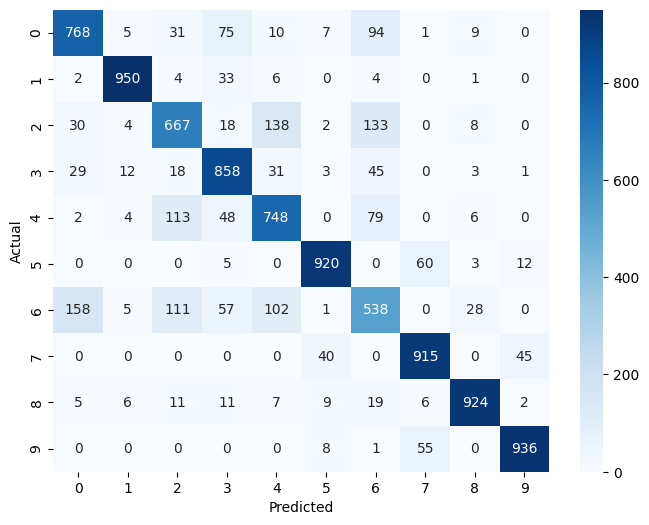

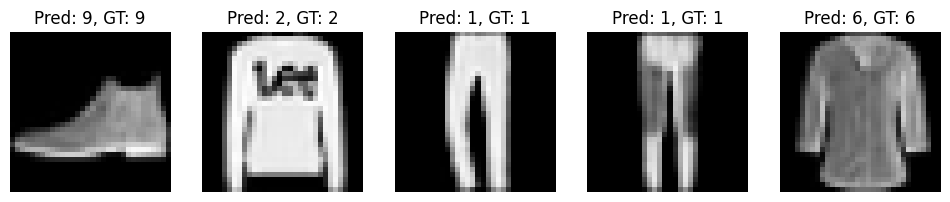

In [ ]:
plot_losses(train_losses_1, val_losses_1)
evaluate_model(adapted_model_1, loaders['mnist_test'])
visualize_predictions(adapted_model_1, loaders['mnist_test'])

In [ ]:
print(f"Evaluating Transfer Strategy {2}...")
adapted_model_2 = apply_transfer_strategy(copy.deepcopy(model), 2)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, adapted_model_2.parameters()), lr=0.001)
adapted_model_2, train_losses_2, val_losses_2 = train_model(adapted_model_2, loaders['mnist_train'], loaders['mnist_val'], criterion, optimizer, num_epochs=10)

Evaluating Transfer Strategy 2...
Epoch 1/10, Train Loss: 0.4224, Train Acc: 0.8473, Val Loss: 0.3483, Val Acc: 0.8657
Epoch 2/10, Train Loss: 0.3073, Train Acc: 0.8884, Val Loss: 0.3051, Val Acc: 0.8845
Epoch 3/10, Train Loss: 0.2672, Train Acc: 0.9024, Val Loss: 0.2980, Val Acc: 0.8927
Epoch 4/10, Train Loss: 0.2353, Train Acc: 0.9131, Val Loss: 0.2772, Val Acc: 0.8980
Epoch 5/10, Train Loss: 0.2096, Train Acc: 0.9213, Val Loss: 0.2572, Val Acc: 0.9083
Epoch 6/10, Train Loss: 0.1874, Train Acc: 0.9292, Val Loss: 0.2703, Val Acc: 0.9027
Epoch 7/10, Train Loss: 0.1673, Train Acc: 0.9371, Val Loss: 0.2667, Val Acc: 0.9068
Epoch 8/10, Train Loss: 0.1488, Train Acc: 0.9431, Val Loss: 0.2828, Val Acc: 0.9060
Early stopping triggered.


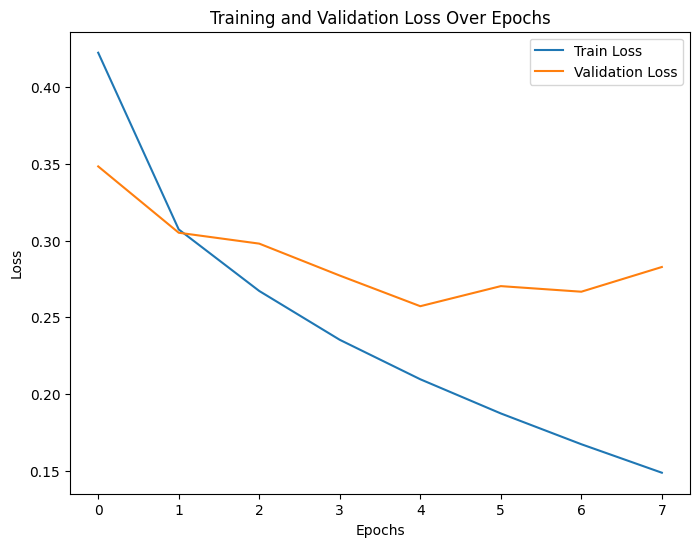


Accuracy: 0.8993, Precision: 0.8994, Recall: 0.8993, F1 Score: 0.8991

              precision    recall  f1-score   support

           0     0.8583    0.8240    0.8408      1000
           1     0.9939    0.9780    0.9859      1000
           2     0.8150    0.8590    0.8364      1000
           3     0.9051    0.8870    0.8960      1000
           4     0.8118    0.8500    0.8305      1000
           5     0.9761    0.9810    0.9786      1000
           6     0.7471    0.7150    0.7307      1000
           7     0.9633    0.9440    0.9535      1000
           8     0.9743    0.9860    0.9801      1000
           9     0.9491    0.9690    0.9589      1000

    accuracy                         0.8993     10000
   macro avg     0.8994    0.8993    0.8991     10000
weighted avg     0.8994    0.8993    0.8991     10000





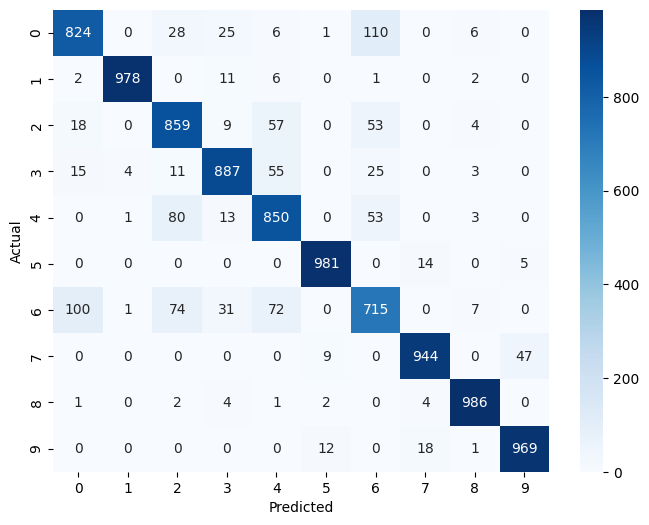

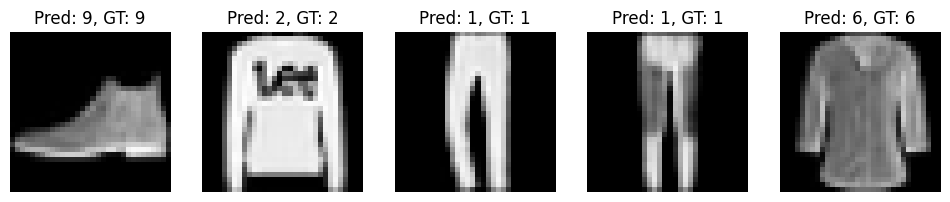

In [ ]:
plot_losses(train_losses_2, val_losses_2)
evaluate_model(adapted_model_2, loaders['mnist_test'])
visualize_predictions(adapted_model_2, loaders['mnist_test'])

In [ ]:
print(f"Evaluating Transfer Strategy {3}...")
adapted_model_3 = apply_transfer_strategy(copy.deepcopy(model), 3)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, adapted_model_3.parameters()), lr=0.001)
adapted_model_3, train_losses_3, val_losses_3 = train_model(adapted_model_3, loaders['mnist_train'], loaders['mnist_val'], criterion, optimizer, num_epochs=10)

Evaluating Transfer Strategy 3...
Epoch 1/10, Train Loss: 0.4177, Train Acc: 0.8501, Val Loss: 0.3272, Val Acc: 0.8732
Epoch 2/10, Train Loss: 0.3058, Train Acc: 0.8874, Val Loss: 0.3017, Val Acc: 0.8843
Epoch 3/10, Train Loss: 0.2614, Train Acc: 0.9037, Val Loss: 0.2928, Val Acc: 0.8870
Epoch 4/10, Train Loss: 0.2364, Train Acc: 0.9119, Val Loss: 0.2452, Val Acc: 0.9085
Epoch 5/10, Train Loss: 0.2189, Train Acc: 0.9186, Val Loss: 0.2421, Val Acc: 0.9128
Epoch 6/10, Train Loss: 0.1979, Train Acc: 0.9268, Val Loss: 0.2373, Val Acc: 0.9115
Epoch 7/10, Train Loss: 0.1825, Train Acc: 0.9319, Val Loss: 0.2364, Val Acc: 0.9117
Epoch 8/10, Train Loss: 0.1688, Train Acc: 0.9376, Val Loss: 0.2415, Val Acc: 0.9147
Epoch 9/10, Train Loss: 0.1523, Train Acc: 0.9428, Val Loss: 0.2333, Val Acc: 0.9132
Epoch 10/10, Train Loss: 0.1411, Train Acc: 0.9467, Val Loss: 0.2347, Val Acc: 0.9163


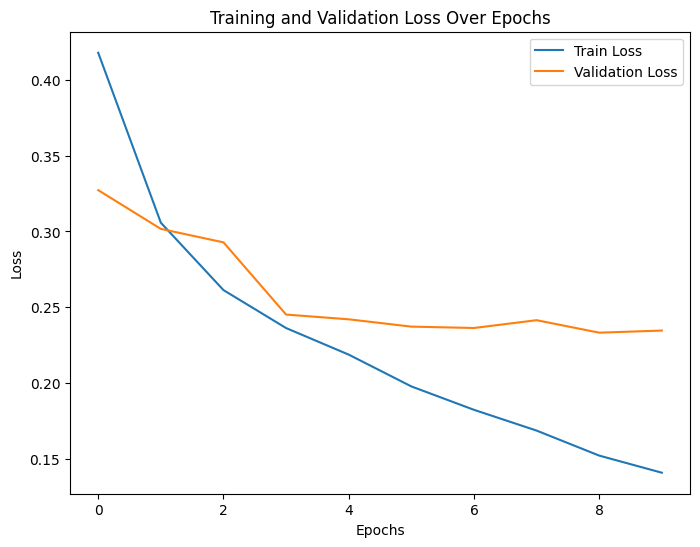


Accuracy: 0.9141, Precision: 0.9155, Recall: 0.9141, F1 Score: 0.9143

              precision    recall  f1-score   support

           0     0.8867    0.8140    0.8488      1000
           1     0.9949    0.9810    0.9879      1000
           2     0.8688    0.8610    0.8649      1000
           3     0.9412    0.8970    0.9186      1000
           4     0.8303    0.9150    0.8706      1000
           5     0.9899    0.9780    0.9839      1000
           6     0.7398    0.7650    0.7522      1000
           7     0.9688    0.9610    0.9649      1000
           8     0.9745    0.9920    0.9832      1000
           9     0.9597    0.9770    0.9683      1000

    accuracy                         0.9141     10000
   macro avg     0.9155    0.9141    0.9143     10000
weighted avg     0.9155    0.9141    0.9143     10000





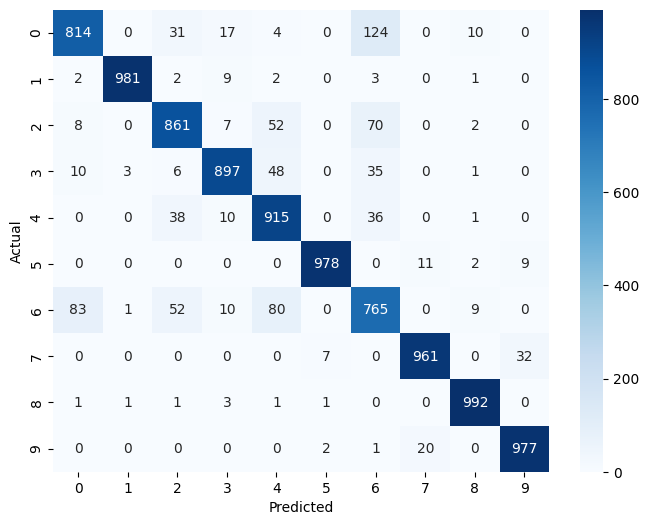

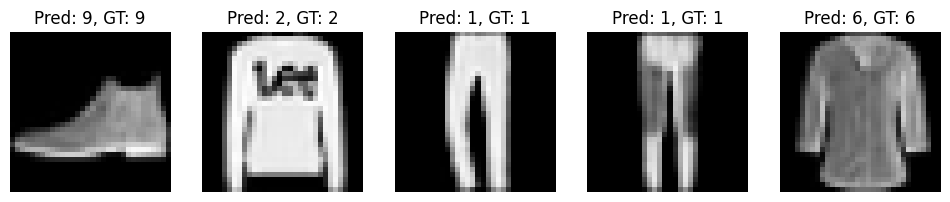

In [ ]:
plot_losses(train_losses_3, val_losses_3)
evaluate_model(adapted_model_3, loaders['mnist_test'])
visualize_predictions(adapted_model_3, loaders['mnist_test'])